In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision
import random
from PIL import Image
import cv2
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!pip install evaluate jiwer


In [4]:
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

#  **Load dataset**

### Tokenize our labels

In [5]:
def exec_label(path):
    return path[path.find('-') + 1:path.find('.')]

input_dir_train = '/kaggle/input/labtinkoff/CCPD2019-dl1/train'

numbers = [exec_label(path) for  path in os.listdir(input_dir_train)]

In [6]:
seq = ''
for number in numbers:
    seq += number
alphabet = ''
for symbol in sorted(set(seq)):
    alphabet += symbol
alphabet    

'0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ云京冀吉宁川新晋桂沪津浙渝湘琼甘皖粤苏蒙藏豫贵赣辽鄂闽陕青鲁黑'

In [7]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

In [8]:
tokenizer = Tokenizer(alphabet)

In [9]:
class Laba_dataset(torch.utils.data.Dataset):
    def __init__(self, root, tokenizer, transform=None):
        self.root = root
        self.transform = transform
        self.tokenizer = tokenizer
        self.img_paths = [os.path.join(self.root, img_path) for img_path in os.listdir(self.root)]
        self.labels = [exec_label(path) for path in os.listdir(self.root)]
        self.enc_labels = self.tokenizer.encode(self.labels)
    
    def __getitem__(self, ind):
        img = cv2.imread(self.img_paths[ind], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 32)) # resize
        if self.transform is not None:
            img = self.transform(img) / 255
        else:
            img = torch.from_numpy(img).float() / 255
        return (img.unsqueeze(0), torch.LongTensor(self.enc_labels[ind]), self.labels[ind])

    def __len__(self):
        return len(self.img_paths)

In [10]:
def collate_fn(batch):
    images, enc_texts, texts = zip(*batch)
    images = torch.stack(images, 0)
    enc_pad_texts = torch.nn.utils.rnn.pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, enc_pad_texts, texts

In [11]:
from sklearn.model_selection import train_test_split
batch_size = 128
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ToTensor()
        ])
dataset_full = Laba_dataset(input_dir_train, tokenizer)
# split full dataset
train_idx, valid_idx = train_test_split(list(range(len(dataset_full))), train_size=0.9)
dataset = {
    'train': torch.utils.data.Subset(dataset_full, train_idx),
    'valid': torch.utils.data.Subset(dataset_full, valid_idx)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    ),
}

In [12]:
input_dir_test = '/kaggle/input/labtinkoff/CCPD2019-dl1/test'
batch_size = 128
transform_test = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(mean=(0.406), std=(0.225))
        ])
dataset_test = Laba_dataset(input_dir_test, tokenizer)
dataloader_test = torch.utils.data.DataLoader(
        dataset=dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )

In [13]:
next(iter(dataloader['train']))[0].shape

torch.Size([128, 1, 32, 128])

In [14]:
img = torchvision.transforms.ToPILImage()(dataset_full[0][0])

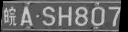

In [15]:
img

### Make some augmentation

## Define model

In [16]:
from torch import nn

In [17]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, 1, stride=2)
        
    def forward(self, x, identity=True):
        out = self.dropout(self.bn(self.conv(x)))
        if identity:
            if self.downsample is not None:
                x = self.downsample(x)
            return self.relu(out + x)
        else: 
            return self.relu(out)
    
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_layers=2, dropout=0.1):
        super().__init__()
        self.start = ResNetBlock(1, 64, 7, 1, 0, 0.0)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.blocks1 = nn.ModuleList([ResNetBlock(64, 64, padding=1) for _ in range(num_layers)])
        self.blocks2 = nn.ModuleList([ResNetBlock(64, 128, padding=1, stride=2)] + [ResNetBlock(128, 128, padding=1) for _ in range(num_layers)])
        self.blocks3 = nn.ModuleList([ResNetBlock(128, 256, padding=1, stride=2)] + [ResNetBlock(256, 256, padding=1) for _ in range(num_layers)])
        self.blocks4 = nn.ModuleList([ResNetBlock(256, 512, padding=1, stride=2)] + [ResNetBlock(512, 512, padding=1) for _ in range(num_layers)])
        self.blocks5 = nn.ModuleList([ResNetBlock(512, 1024, padding=1, stride=2)] + [ResNetBlock(1024, 1024, padding=1) for _ in range(num_layers)])
        
        
    def forward(self, x):
        out = self.maxpool(self.start(x, identity=False))
        for layer in self.blocks1:
            out = layer(out)
            
        for layer in self.blocks2:
            out = layer(out)
            
        for layer in self.blocks3:
            out = layer(out)
            
        for layer in self.blocks4:
            out = layer(out)
            
        for layer in self.blocks5:
            out = layer(out)
            
        return out

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=3,
    ):
        super().__init__()
        self.feature_extractor = CNN()
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

### Define accuracy metric for evaluate validation dataset

In [18]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

# Training loop

In [19]:
import pickle as pkl

def safe(obj, filename):
    with open(filename, 'wb') as outp:
        pkl.dump(obj, outp)
        
def read(filename):
    with open(filename, 'rb') as inp:
        return pkl.load(inp)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [21]:
def val_loop(data_loader, model, tokenizer, device):
    model.eval()
    acc_avg = AverageMeter()
    for images, enc_texts, texts in data_loader:
        batch_size = len(texts)
        text_preds = predict(images, model, tokenizer, device)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    return acc_avg.avg

def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds

def train_loop(data_loader, model, criterion, optimizer, epoch):
    loss_avg = AverageMeter()
    model.train()
    for images, enc_texts, texts in data_loader:
        model.zero_grad()
        images = images.to(device)
        batch_size = len(texts)
        output = model(images)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        text_lens = torch.LongTensor([len(text) for text in texts])
        loss = criterion(output, enc_texts, output_lenghts, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg

def train(dataloader, epochs):
    train_loader, val_loader = dataloader['train'], dataloader['valid']
    model = CRNN(number_class_symbols=tokenizer.get_num_chars())
    model.apply(weights_init)
    model.to(device)

    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,
                                  weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode='max', factor=0.5, patience=15)
    best_acc = -np.inf
    acc_avg = val_loop(val_loader, model, tokenizer, device)
    for epoch in range(epochs):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        acc_avg = val_loop(val_loader, model, tokenizer, device)
        scheduler.step(acc_avg)
        if acc_avg > best_acc:
            best_acc = acc_avg
        safe(model, f'model_{epoch}')

In [24]:
train(dataloader, 10)

KeyboardInterrupt: 

In [32]:
img, enc_label, label = dataset_full[2001]

In [33]:
pred = predict(img.unsqueeze(0).to(device), model, tokenizer, device)
pred

['9']

In [ ]:
real_img = torchvision.transforms.ToPILImage()(img)
real_img

# Compute metrics

In [1]:
from evaluate import load
cer = load("cer")

In [23]:
model = CRNN(number_class_symbols=tokenizer.get_num_chars())
references = dataset_test.labels

In [24]:
predictions = []
for img, enc_text, text in dataloader_test:
    predictions += predict(img, model, tokenizer, device)

In [27]:
cer_score = cer.compute(predictions=references, references=references)
print(cer_score)

0.0
